# **WARNINGS**

* **I have used Adjusted Price (not Target)**

* **Securities Code : 9994**

* **My LSTM model predict only next(tomorrow) day (first Day of Supplemental files)**

* **If you use all of supplemental file and Securities Codes, you will get high score beacuse of few days in  supplemental files.** 

* **But do not remember, after end of competition, we will have 3 months for prediction. LSTM model use previous days data this notebook(60 days).**

* **Atfer fitting model, if we predict next day, we will get little mse and if we predict 2 days later, Model will add next day to prediction. Because next day will be previous for 2 days later.**

* **The error will increase for each predicted day. It is difficult to say how it will good results in 3 months.**

# Results: 
# Date 2021-12-06 (first date of supp files)
# Prediction :2438.73
# Actual : 2418.0

# LSTM Template

## How it Works

### First 60 columns are features and we have target

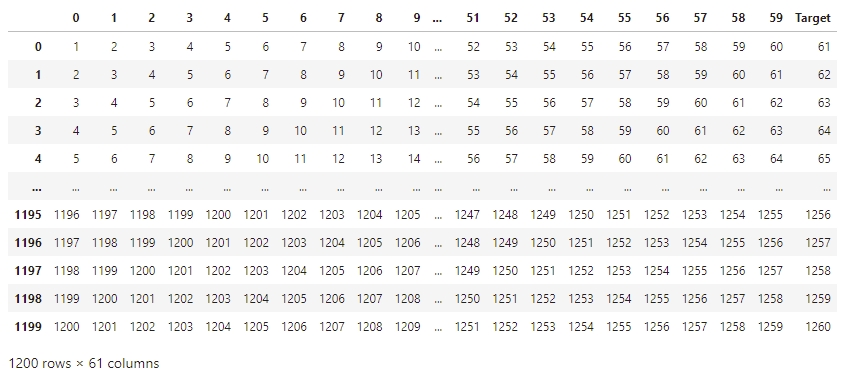

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from decimal import ROUND_HALF_UP, Decimal
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [ ]:
df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
df = adjust_price(df)

df = df.loc[df["SecuritiesCode"] == 9994].copy()
col = "AdjustedClose"
data = df.filter([col])

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Close Price History for 9994",fontsize=18)
plt.plot(df[col])
plt.xlabel("Date",fontsize=18)
plt.ylabel("AdjustedClose")
plt.show()

# Train and validation split

In [ ]:
import math
dataset  = data.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

# MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

# LSTM for previous 60 days

# How it works, What are the features and target?

In [ ]:
df_x = []

for i in range(1,1201):
    df_x.append([*range(i,i+61)])
df_x=pd.DataFrame(df_x)
df_x.rename(columns = {60:'Target'}, inplace = True)

### Values of 60 columns are features and we have target

In [ ]:
df_x

# MODEL

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

In [ ]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
plt.figure(figsize=(20,8))
plt.title("Model for 9994")
plt.xlabel("Date", fontsize = 28)
plt.ylabel(col,fontsize=28)
plt.plot(train[col])
plt.plot(valid[[col,"Predictions"]])
plt.legend(["Train","Val","Predictions"])

# We fit model and we are predicting next day (first day of supplemental files)

In [ ]:
df_price_test = df.copy()
new_df = df_price_test.filter([col])
last_60_days = new_df[-60:].values
last_60_days_scaled = sc.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = sc.inverse_transform(pred_price)
print(pred_price)

In [ ]:
df_supp =  pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")

In [ ]:
df_supp = adjust_price(df_supp)

In [ ]:
actual = df_supp[df_supp["SecuritiesCode"]==9994].iloc[0]["AdjustedClose"]
actual

# Date 2021-12-06 (first date of supp files)
# Prediction :2438.73
# Actual : 2418.0

In [ ]:
(pred_price-actual).item()

# Upvote! for getting all supp files prediction 